In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline

In [2]:
my_data_dir = 'D:\\Eye Classification\\Datasets\\'

In [3]:
# CONFIRM THAT THIS REPORTS BACK 'test', and 'train'
os.listdir(my_data_dir) 

['test', 'train']

In [4]:
test_path = my_data_dir+'\\test\\'
train_path = my_data_dir+'\\train\\'

In [5]:
os.listdir(test_path)

['Red Eye', 'White Eye']

In [6]:
os.listdir(train_path)

['Red Eye', 'White Eye']

In [7]:
os.listdir(train_path+'\\Red Eye')[0]

'27.jpg'

In [8]:
Red_Eye = train_path+'\\Red Eye'+'\\27.jpg'

In [9]:
red_img= imread(Red_Eye)

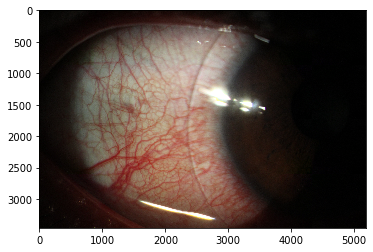

In [10]:
plt.imshow(red_img)

In [11]:
red_img.shape

(3456, 5184, 3)

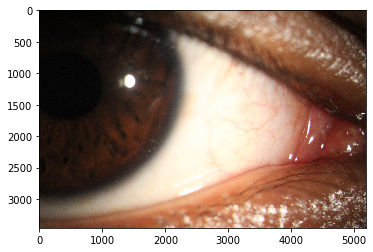

In [12]:
white_eye_path = train_path+'\\White Eye\\'+os.listdir(train_path+'\\White Eye')[0]
white_eye = imread(white_eye_path)
plt.imshow(white_eye)

**Let's check how many images there are.**

In [13]:
len(os.listdir(train_path+'\\White Eye'))

99

In [14]:
len(os.listdir(train_path+'\\Red Eye'))

99

**Let's find out the average dimensions of these images.**

In [15]:
white_eye.shape

(3456, 5184, 3)

In [16]:
red_img.shape

(3456, 5184, 3)

In [17]:
dim1 = []
dim2 = []
for image_filename in os.listdir(test_path+'\\White Eye'):
    
    img = imread(test_path+'\\White Eye'+'\\'+image_filename)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

In [19]:
np.mean(dim1)

3456.0

In [20]:
np.mean(dim2)

5184.0

In [21]:
image_shape = (120,120,3)

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [24]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

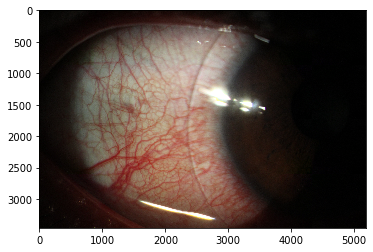

In [25]:
plt.imshow(red_img)

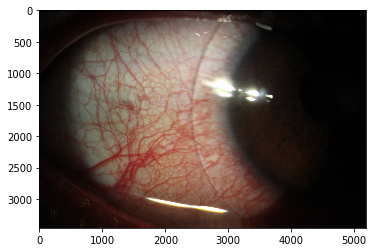

In [26]:
plt.imshow(image_gen.random_transform(red_img))

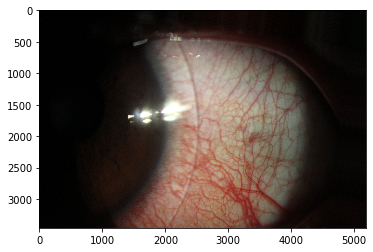

In [27]:
plt.imshow(image_gen.random_transform(red_img))

In [28]:
image_gen.flow_from_directory(train_path)

Found 198 images belonging to 2 classes.


In [29]:
image_gen.flow_from_directory(test_path)

Found 98 images belonging to 2 classes.


# Creating the Model

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [31]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())


model.add(Dense(128))
model.add(Activation('relu'))

# Dropouts help reduce overfitting by randomly turning neurons off during training.
# Here we say randomly turn off 50% of neurons.
model.add(Dropout(0.5))

# Last layer, remember its binary so we use sigmoid
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 118, 118, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 59, 59, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 57, 57, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 10816)             0

## Early Stopping

In [33]:
from tensorflow.keras.callbacks import EarlyStopping

In [34]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

## Training the Model

In [36]:
batch_size = 16

In [37]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 198 images belonging to 2 classes.


In [38]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 98 images belonging to 2 classes.


In [39]:
train_image_gen.class_indices

{'Red Eye': 0, 'White Eye': 1}

In [40]:
import warnings
warnings.filterwarnings('ignore')

In [41]:
results = model.fit_generator(train_image_gen,epochs=3,
                              validation_data=test_image_gen,
                             callbacks=[early_stop])

Epoch 1/3
13/13 [==============================] - 179s 14s/step - loss: 0.4713 - accuracy: 0.7879 - val_loss: 0.1090 - val_accuracy: 1.0000
Epoch 2/3
13/13 [==============================] - 124s 10s/step - loss: 0.0984 - accuracy: 0.9697 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 3/3
13/13 [==============================] - 120s 9s/step - loss: 0.0143 - accuracy: 0.9949 - val_loss: 8.1023e-04 - val_accuracy: 1.0000


In [42]:
from tensorflow.keras.models import load_model
model.save('eyeclass.h5')

# Evaluating the Model

In [43]:
losses = pd.DataFrame(model.history.history)

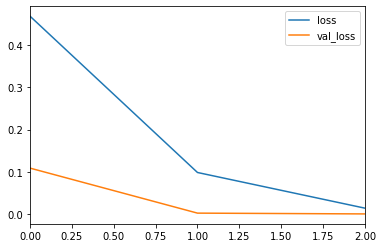

In [44]:
losses[['loss','val_loss']].plot()

In [45]:
model.metrics_names

['loss', 'accuracy']

In [46]:
model.evaluate_generator(test_image_gen)

[0.0006962556496716843, 1.0]

In [47]:
from tensorflow.keras.preprocessing import image

In [48]:
pred_probabilities = model.predict_generator(test_image_gen)

In [49]:
pred_probabilities

array([[7.7962875e-05],
       [3.9970875e-03],
       [4.8577785e-06],
       [1.4126301e-05],
       [6.2286854e-06],
       [1.9371510e-06],
       [2.5629997e-06],
       [5.9604645e-06],
       [4.6491623e-06],
       [4.7385693e-06],
       [9.9241734e-06],
       [3.0398369e-06],
       [1.8477440e-06],
       [2.5349855e-03],
       [7.4207783e-06],
       [3.0964613e-05],
       [6.3180923e-06],
       [1.2814999e-06],
       [6.4656138e-04],
       [1.0937452e-05],
       [4.3511391e-06],
       [1.5795231e-06],
       [3.9438099e-02],
       [7.7098608e-05],
       [1.0655224e-03],
       [4.0084124e-05],
       [1.1593103e-05],
       [1.1479855e-03],
       [4.6491623e-06],
       [2.0990074e-03],
       [1.9669533e-06],
       [5.7518482e-06],
       [7.3462665e-02],
       [3.1113625e-05],
       [1.7938614e-03],
       [2.0861626e-06],
       [4.5645237e-03],
       [2.7418137e-06],
       [2.1848083e-04],
       [9.1552734e-05],
       [8.7320805e-06],
       [3.665685

In [50]:
test_image_gen.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [51]:
predictions = pred_probabilities > 0.5

In [52]:
# Numpy can treat this as True/False for us
predictions

array([[False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [

In [53]:
from sklearn.metrics import classification_report,confusion_matrix

In [54]:
print(classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        49
           1       1.00      1.00      1.00        49

    accuracy                           1.00        98
   macro avg       1.00      1.00      1.00        98
weighted avg       1.00      1.00      1.00        98



In [55]:
confusion_matrix(test_image_gen.classes,predictions)

array([[49,  0],
       [ 0, 49]], dtype=int64)

# Predicting on an Image

In [68]:
sample='D:\\Eye Classification\\Datasets\\test\\White Eye\\IMG_0003_36.jpg'

In [69]:
my_image = image.load_img(sample,target_size=image_shape)

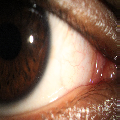

In [70]:
my_image

In [71]:
type(my_image)

PIL.Image.Image

In [72]:
my_image = image.img_to_array(my_image)

In [73]:
type(my_image)

numpy.ndarray

In [74]:
my_image.shape

(120, 120, 3)

In [75]:
my_image = np.expand_dims(my_image, axis=0)

In [76]:
my_image.shape

(1, 120, 120, 3)

In [89]:
result=print(model.predict(my_image)) # 1 means White Eye and O means Red Eye
result

[[1.]]


In [78]:
train_image_gen.class_indices

{'Red Eye': 0, 'White Eye': 1}

In [79]:
test_image_gen.class_indices

{'Red Eye': 0, 'White Eye': 1}